In [1]:
'''
reference: 
    https://arxiv.org/abs/1508.01211
    https://www.tensorflow.org/tutorials/text/nmt_with_attention
    https://github.com/jameslyons/python_speech_features
    https://www.tensorflow.org/tutorials/customization/custom_layers
    
data source: 
    https://www.kaggle.com/c/tensorflow-speech-recognition-challenge
'''

import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import io
import time

In [12]:
import os
import librosa # for audio processing
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.io import wavfile # for audio processing
import warnings
warnings.filterwarnings("ignore")

In [3]:
class WaveReader:
    def __init__(self, path, sample_rate, padding_type, read_size):
        '''
        Args:
            path: train path containing directory which one would like to load
            sample_rate: sample rate for reading .wav file
            padding_type: padding for .wav data length less than 1 second
            read_size: size that one would like to read
        '''
        
        self.path = path
        self.sample_rate = sample_rate
        self.padding_type = padding_type
        self.read_size = read_size

    def read(self, labels=None):
        '''
        read all the data under the labels(directories) one select
        
        Args:
            labels: labels(directories) one would like to load
                    None means read all the directories under that directory
        '''
        print("LABEL\tTOTAL\tREAD\tSAVED\t<1s COUNT")
        print("-----\t-----\t----\t-----\t---------")
        
        if labels is None:
            labels = [f for f in os.listdir(path) if os.path.isdir(path + "\\" + f)]
            
        elif type(labels) == str:
            samples, total_wave_count, total_wave_read, total_loss_count = self.read_dir(dir_name=labels)
            sample_labels = np.repeat(labels, total_wave_read)
            
            print("\n\nMISSION COMPELTE!!!")
            return samples, sample_labels, total_wave_count, total_loss_count
                    
        label_len = len(labels)
        total_wave_count = np.zeros(label_len, dtype=np.int32)
        total_wave_read = np.zeros(label_len, dtype=np.int32)
        total_loss_count = np.zeros(label_len, dtype=np.int32)

        
        for i, lab in enumerate(labels):
            samp, total_wave_count[i], total_wave_read[i], total_loss_count[i] = self.read_dir(dir_name=lab)
            
            if i == 0:
                samples = samp
                sample_labels = np.repeat(lab, total_wave_read[i])
            else:
                samples = np.concatenate((samples, samp), axis=0)
                sample_labels = np.concatenate((sample_labels, np.repeat(lab, total_wave_read[i])), axis=None)
        
        print("\n\nMISSION COMPELTE!!!")
        return samples, sample_labels, total_wave_count, total_loss_count
    
    def read_dir(self, dir_name):
        '''
        read one directory of given directory name
        
        Args:
            dir_name: directory name
        '''
        dir_path = os.path.join(self.path, dir_name)
        wave_files = [f for f in os.listdir(dir_path) if f.endswith('.wav')]
        total_wave_files = len(wave_files)

        if self.read_size is not None:
            wave_files_read = self.read_size
        else:
            wave_files_read = total_wave_files

        samples = np.zeros((wave_files_read, self.sample_rate))
        less_than_1s_count = 0
        num_of_file_read = 0
        for i, wav_file in enumerate(wave_files):
            wave_file_path = os.path.join(dir_path, wav_file)
            samp, _ = librosa.load(wave_file_path, sr=self.sample_rate)

            pad_size = self.sample_rate - len(samp)
            if pad_size > 0:
                less_than_1s_count += 1
                if self.padding_type is None:
                    # None: than skip this wave file
                    continue

                elif self.padding_type == "white_noise":
                    # white_noise: pad white noise data behind
                    padding = np.random.normal(0, 0.02, pad_size)
                    samples[num_of_file_read, :] = np.concatenate((samp, padding), axis=None)
                    num_of_file_read += 1


                elif self.padding_type == "zero":
                    # zero: pad zeros behind
                    padding = np.zeros(pad_size)
                    samples[num_of_file_read, :] = np.concatenate((samp, padding), axis=None)
                    num_of_file_read += 1
            else:
                samples[num_of_file_read, :] = samp
                num_of_file_read += 1

            print("{}\t{}\t{}\t{}\t{}".format(dir_name, 
                                              total_wave_files, 
                                              i+1, 
                                              num_of_file_read, 
                                              less_than_1s_count), end="\r")
            
            if num_of_file_read == wave_files_read:
                break
                
        print()

        return samples, total_wave_files, wave_files_read, less_than_1s_count

In [4]:
SAMPLE_RATE = 16000

train_audio_path = os.path.join(os.path.dirname(os.getcwd()), "data", "train", "audio")
phoneme_path = os.path.join(os.getcwd(), "Phonemes")
phoneme_dataframe = pd.read_csv(os.path.join(phoneme_path, "phonemes.csv"))

reader = WaveReader(path=train_audio_path, 
                    sample_rate=SAMPLE_RATE, 
                    padding_type=None, 
                    read_size=2000)

wav_array, label_array, total, loss = reader.read(labels=phoneme_dataframe.words)

# print("\nCheck the existence of NaN and Inf")
# print(f"NaN Number: {np.sum(np.isnan(wav_array))}")
# print(f"Inf Number: {np.sum(np.isinf(wav_array))}")

LABEL	TOTAL	READ	SAVED	<1s COUNT
-----	-----	----	-----	---------
zero	2376	2160	2000	160
one	2370	2262	2000	262
two	2373	2222	2000	222
three	2356	2207	2000	207
four	2372	2201	2000	201
five	2357	2185	2000	185
six	2369	2164	2000	164
seven	2377	2194	2000	194
eight	2352	2232	2000	232
nine	2364	2178	2000	178


MISSION COMPELTE!!!


In [7]:
import IPython.display as ipd

index = np.random.randint(len(wav_array), size=1)
print(f"Index: {index}")
print(label_array[index])
ipd.Audio(wav_array[index], rate=SAMPLE_RATE)

Index: [3165]
['one']


In [9]:
# from python_speech_features import logfbank

# ex_shape = logfbank(simu_wave[0], SAMPLE_RATE).shape
# mfcced_simu_wave = np.zeros(((len(simu_wave), ex_shape[0], ex_shape[1])))
# for i, wave in enumerate(simu_wave):
#     mfcc = logfbank(wave, SAMPLE_RATE)
    
# #     mean = np.mean(mfcc, axis=0)
# #     std = np.std(mfcc, axis=0)
# #     mfcced_simu_wave[i, :, :] = (mfcc - mean) / std
#     mfcced_simu_wave[i, :, :] = mfcc
    
#     print(f"Transfering {i+1}th case", end="\r")

# print()

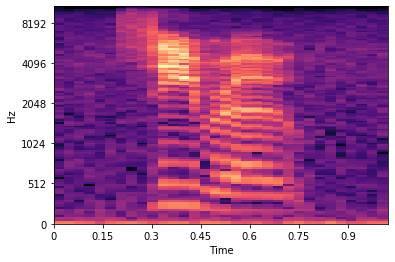

In [13]:
N_FFT = 2048
HOP_LENGTH = 512

samples = wav_array[0]
spectrogram = librosa.feature.melspectrogram(samples, 
                                             sr=SAMPLE_RATE, 
                                             n_fft=512, 
                                             hop_length=HOP_LENGTH)

spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)
show = librosa.display.specshow(spectrogram_db, sr=SAMPLE_RATE, 
                                hop_length=HOP_LENGTH, 
                                x_axis='time', 
                                y_axis='mel')